<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [123]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [124]:
import torchvision
from torchvision.datasets import KMNIST

# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [125]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Если уменьшить `batch_size`, то скорость обучения снизится. А при увеличении `batch_size` скорость обучения выше. В последнем случае это происходит из-за уменьшения кол-ва итераций, уменьшение времени на загрузку данных.

Посмотрим на какую-нибудь картинку:

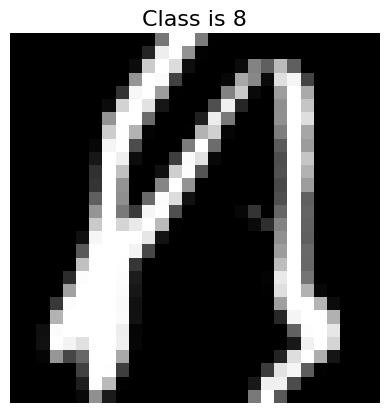

In [126]:
i = 0
plt.imshow(trainset[i][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[i][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

In [127]:
lst_k = list(trainset.class_to_idx.keys())
lst_v = list(trainset.class_to_idx.values())
lst_clases = []
ind_uniq_cls = {}
i = 0
while True and len(lst_clases) != 10:
    if trainset[i][1] not in lst_clases:
        lst_clases.append(trainset[i][1])
        ind_uniq_cls[i] = lst_k[lst_v.index(trainset[i][1])]
    i += 1

ind_uniq_cls

{0: 're',
 1: 'ya',
 2: 'o',
 3: 'ki',
 4: 'na',
 5: 'su',
 10: 'ha',
 15: 'ma',
 18: 'wo',
 21: 'tsu'}

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





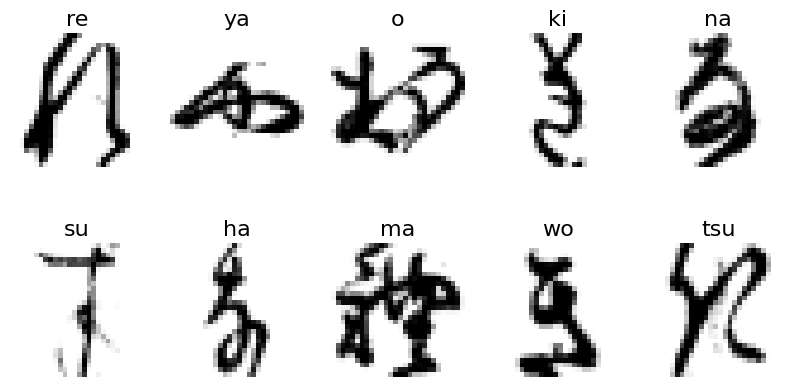

In [128]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

c = 0
for _ in range(5):
    i = list(ind_uniq_cls.keys())[c]
    ax[0, i].imshow(trainset[i][0].view(28, 28).numpy(), cmap="binary")
    ax[0, i].set_title(f'{list(ind_uniq_cls.values())[c]}', size = 16)
    ax[0, i].axis('off')
    ax[1, i].imshow(trainset[i+5][0].view(28, 28).numpy(), cmap="binary")
    ax[1, i].set_title(f'{list(ind_uniq_cls.values())[c+5]}', size = 16)
    ax[1, i].axis('off')
    c += 1

plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [129]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() # Наследуемся.Запомнил (･ω･)b
        # определяем два слоя
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x) # в шаблоне на выходе logits, поэтому выходят логиты.

        return logits


Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** Подумал над активацией после последнего слоя. Использовал бы softmax, он часто используется для задач классификации.
Общее кол-во обучаемых параметров с тремя слоями:
(28∗28∗256)+(256∗128)+(128∗10)+256+128+10=235146
Где кол-во весов:
(28∗28∗256)+(256∗128)+(128∗10) = 234752
И кол-во смещений:
256 + 128 + 10 = 394

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [130]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [131]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [132]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9143
Epoch=2 loss=0.4389
Epoch=3 loss=0.3499
Epoch=4 loss=0.2932
Epoch=5 loss=0.2521
Epoch=6 loss=0.2181
Epoch=7 loss=0.1899
Epoch=8 loss=0.1674
Epoch=9 loss=0.1471
Epoch=10 loss=0.1296


In [133]:
get_accuracy(fc_net, testloader)

0.8786

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [134]:
mean = trainset.data.float().mean() / 255
std = trainset.data.float().std() / 255
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [136]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [137]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6907
Epoch=2 loss=0.3091
Epoch=3 loss=0.2272
Epoch=4 loss=0.1769
Epoch=5 loss=0.1407
Epoch=6 loss=0.1148
Epoch=7 loss=0.0944
Epoch=8 loss=0.0768
Epoch=9 loss=0.0622
Epoch=10 loss=0.0511


In [138]:
get_accuracy(fc_net, testloader)

0.8973

Как изменилась `accuracy` после нормализации?

До 0.8786, после 0.8973. Точность выше после нормализации.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [139]:
act_f = {'sig': nn.Sigmoid,
         'gel': nn.GELU,
         'tan': nn.Tanh}
blocks = {}

for name, func in act_f.items():
    blocks[f'{name}'] = nn.Sequential(nn.Flatten(),
                                            nn.Linear(28*28, 256),
                                            func(),
                                            nn.Linear(256,128),
                                            func(),
                                            nn.Linear(128,10)
                                            )

In [140]:
# Создадим объект модели
fc_net = {}
loss_function = {}
optimizer = {}

for block in blocks:
    fc_net[f'{block}'] = blocks[block]
    # Определим функцию потерь
    loss_function[f'{block}'] = nn.CrossEntropyLoss()
    # Создадим оптимизатор для нашей сети
    lr = 0.001 # скорость обучения
    optimizer[f'{block}'] = torch.optim.Adam(fc_net[f'{block}'].parameters(), lr=3e-4)

In [141]:
n_epochs = 10

for block in blocks:
    loss_history = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer[f'{block}'].zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net[f'{block}'](images) # делаем предсказания
            loss = loss_function[f'{block}'](outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer[f'{block}'].step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"For {block} Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

For sig Epoch=1 loss=1.5475
For sig Epoch=2 loss=0.7532
For sig Epoch=3 loss=0.5500
For sig Epoch=4 loss=0.4488
For sig Epoch=5 loss=0.3802
For sig Epoch=6 loss=0.3265
For sig Epoch=7 loss=0.2836
For sig Epoch=8 loss=0.2480
For sig Epoch=9 loss=0.2182
For sig Epoch=10 loss=0.1926
For gel Epoch=1 loss=0.6522
For gel Epoch=2 loss=0.2782
For gel Epoch=3 loss=0.2010
For gel Epoch=4 loss=0.1544
For gel Epoch=5 loss=0.1212
For gel Epoch=6 loss=0.0982
For gel Epoch=7 loss=0.0777
For gel Epoch=8 loss=0.0625
For gel Epoch=9 loss=0.0492
For gel Epoch=10 loss=0.0394
For tan Epoch=1 loss=0.7745
For tan Epoch=2 loss=0.3835
For tan Epoch=3 loss=0.2573
For tan Epoch=4 loss=0.1842
For tan Epoch=5 loss=0.1375
For tan Epoch=6 loss=0.1023
For tan Epoch=7 loss=0.0771
For tan Epoch=8 loss=0.0574
For tan Epoch=9 loss=0.0422
For tan Epoch=10 loss=0.0315


In [142]:
for block in blocks:
    print(f'For activation function as {block}:')
    print(get_accuracy(fc_net[f'{block}'], testloader))

For activation function as sig:
0.8544
For activation function as gel:
0.9046
For activation function as tan:
0.9


С использованием какой функции активации удалось достичь наибольшей `accuracy`?

Используя функцию активации GELU удалось достичь наибольшей точности (0.905) в сравнении с Sigmoid (0.854) и Tanh (0.9).

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [143]:
import torch.nn as nn

func = nn.GELU

block_gel = nn.Sequential(nn.Flatten(),
                          nn.Linear(28*28, 256),
                          func(),
                          nn.Linear(256,128),
                          func(),
                          nn.Linear(128,10)
                          )

fc_net = block_gel
loss_function = nn.CrossEntropyLoss()
lr = 3e-4
optimizers = {'adam': torch.optim.Adam(fc_net.parameters(), lr=lr),
             'rms': torch.optim.RMSprop(fc_net.parameters(), lr=lr),
             'adagrad': torch.optim.Adagrad(fc_net.parameters(), lr=lr)
             }
result = {}

n_epochs = 10

for name, optim in optimizers.items():
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizers[name].zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizers[name].step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Optimizer is {name}: Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    result[name] = f'{get_accuracy(fc_net, trainloader)}'


Optimizer is adam: Epoch=1 loss=0.6630
Optimizer is adam: Epoch=2 loss=0.2815
Optimizer is adam: Epoch=3 loss=0.2033
Optimizer is adam: Epoch=4 loss=0.1551
Optimizer is adam: Epoch=5 loss=0.1221
Optimizer is adam: Epoch=6 loss=0.0969
Optimizer is adam: Epoch=7 loss=0.0776
Optimizer is adam: Epoch=8 loss=0.0624
Optimizer is adam: Epoch=9 loss=0.0491
Optimizer is adam: Epoch=10 loss=0.0385
Optimizer is rms: Epoch=1 loss=0.0495
Optimizer is rms: Epoch=2 loss=0.0268
Optimizer is rms: Epoch=3 loss=0.0210
Optimizer is rms: Epoch=4 loss=0.0174
Optimizer is rms: Epoch=5 loss=0.0120
Optimizer is rms: Epoch=6 loss=0.0098
Optimizer is rms: Epoch=7 loss=0.0083
Optimizer is rms: Epoch=8 loss=0.0072
Optimizer is rms: Epoch=9 loss=0.0062
Optimizer is rms: Epoch=10 loss=0.0078
Optimizer is adagrad: Epoch=1 loss=0.0015
Optimizer is adagrad: Epoch=2 loss=0.0010
Optimizer is adagrad: Epoch=3 loss=0.0009
Optimizer is adagrad: Epoch=4 loss=0.0009
Optimizer is adagrad: Epoch=5 loss=0.0008
Optimizer is adagr

In [147]:
for name, res in result.items():
    print(f'If optimazer is {name}, accuracy is', '{0:.5}'.format(res))

If optimazer is adam, accuracy is 0.993
If optimazer is rms, accuracy is 0.999
If optimazer is adagrad, accuracy is 1.0


### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [148]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()


    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.max(torch.zeros_like(x), x)
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [149]:
act_f = {'relu': nn.ReLU,
         'cus_relu': CustomReLU}
blocks = {}

for name, func in act_f.items():
    blocks[f'{name}'] = nn.Sequential(nn.Flatten(),
                                            nn.Linear(28*28, 256),
                                            func(),
                                            nn.Linear(256,128),
                                            func(),
                                            nn.Linear(128,10)
                                            )

# Создадим объект модели
fc_net = {}
loss_function = {}
optimizer = {}

for block in blocks:
    fc_net[f'{block}'] = blocks[block]
    # Определим функцию потерь
    loss_function[f'{block}'] = nn.CrossEntropyLoss()
    # Создадим оптимизатор для нашей сети
    optimizer[f'{block}'] = torch.optim.Adam(fc_net[f'{block}'].parameters(), lr=3e-4)

n_epochs = 10

for block in blocks:
    loss_history = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer[f'{block}'].zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net[f'{block}'](images) # делаем предсказания
            loss = loss_function[f'{block}'](outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer[f'{block}'].step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        # print(f"For {block} Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

for block in blocks:
    print(f'For activation function as {block}:')
    print(get_accuracy(fc_net[f'{block}'], testloader))

For activation function as relu:
0.8965
For activation function as cus_relu:
0.8982


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Made by ruDALL-E Kandinsky (XXL)


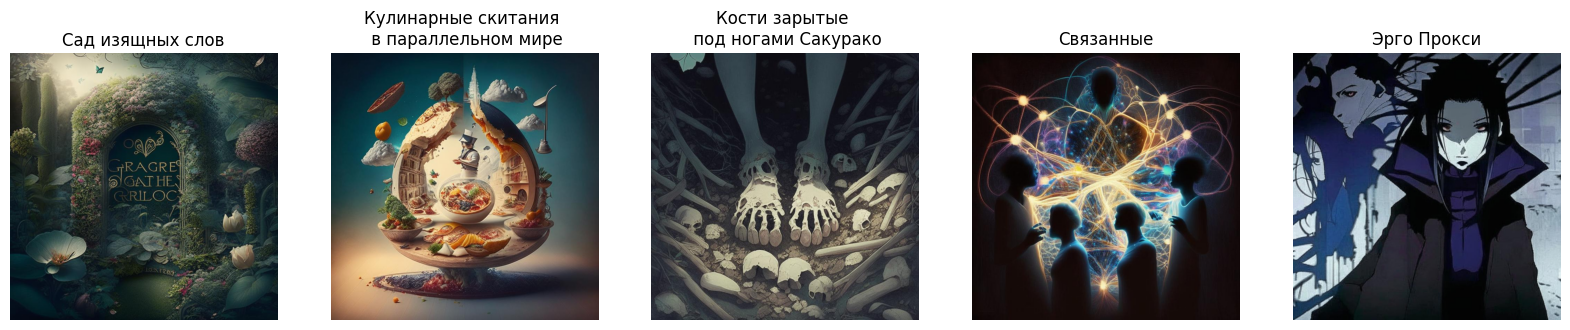

In [150]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

print('Made by ruDALL-E Kandinsky (XXL)')

images = {"Сад изящных слов": "images/Сад изящных слов.jpg",
          "Кулинарные скитания \n в параллельном мире": "images/Кулинарные скитания в параллельном мире.jpg",
          "Кости зарытые \n под ногами Сакурако": "images/Кости зарытые под ногами Сакурако.jpg",
          "Связанные": "images/Связанные.jpg",
          "Эрго Прокси": "images/Эрго Прокси.jpg"
          }

fig, ax = plt.subplots(1, 5, figsize=(20, 10))

i = 0
for name, image in images.items():
    ax[i].set_title(name)
    image = mpimg.imread(image)
    ax[i].imshow(image)
    ax[i].axis('off')
    i += 1

plt.show()